# Training Time

In [1]:
import glob
from pprint import pprint
import pickle
import re

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from slice_generator import SliceGenerator

In [2]:
print("tensorflow version:",tf.__version__)

tensorflow version: 2.2.0-dlenv


## Model variables

In [3]:
frames = 1
channels = 1
pixels_x = 21
pixels_y = 21

## get and save the pwd

In [4]:
model_dir = "../models/"
model_folder = "stack_single_input/"
pwd = model_dir+model_folder
file_list = sorted(glob.glob(pwd+"*"))
pprint(file_list)

['../models/stack_single_input/log.log',
 '../models/stack_single_input/ssi_hist1.pkl',
 '../models/stack_single_input/stack_single_input_1F.h5',
 '../models/stack_single_input/train_val_loss.png']


## Find and load model

In [5]:
# choose a model
models=[]
for file in file_list:
    match = re.search("\.h5$", file)
    if match:
        models.append(file)

assert len(models) > 0, "Hmm, can't seem to find any model files ending in .h5 in "+pwd
if len(models) > 1:
    print("There are more than one models in the directory.\nLoading the first.\n", models)
print("Loading... ")
model = tf.keras.models.load_model(models[0])

model_name = re.search("[^/]*(?=\.[^.]+($|\?))", models[0]).__getitem__(0)
print("Loading done for",model_name)

Loading... 
Loading done for stack_single_input_1F


In [6]:
# model_name += "_"+loss_func_name
# model_name

# Loss, Learning Rate, Optimizer

## Loss
Define a custom loss function. Here it's SSE

In [7]:
loss_func_name = "SSE"
def sum_sq_err(y_true, y_pred):
    return K.sum( K.square(y_true - y_pred), axis=1)
class SumSquaredError(tf.keras.losses.Loss):
    def __init__():
        self.name = "SSE"
    def call(self, y_true, y_pred):
#         y_pred = ops.convert_to_tensor_v2(y_pred)
#         y_true = math_ops.cast(y_true, y_pred.dtype)
        return K.sum( K.square(y_true - y_pred), axis=1)

## lr
Define a Learning rate schedule.

In [8]:
lr = 0.01
# lr = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = 1./3.1415,
#     decay_steps = 1,
#     decay_rate = 0.367,
#     staircase=False,
#     name="inversePi_e_inverse7"
# )

## optimizer
Define an optimizer. Must set ```clipnorm``` to prevent wild things from happening

In [10]:
opt = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=False,
    name='SGD',
    clipnorm=1.0,
)
# tf.keras.optimizers.Adam(learning_rate=lr,
#                                beta_1=0.9,
#                                beta_2=0.999,
#                                epsilon=1e-07,
#                                amsgrad=False,
#                                name='Adam',
#                                clipnorm=1.0)

# Compile the Model

In [11]:
print("Compiling", model_name,"...")
model.compile(
    loss=sum_sq_err,
    optimizer=opt,
    metrics=['mean_absolute_error'])
print("Compiled.")

Compiling stack_single_input_1F ...
Compiled.


# Prepare for training, callbacks
Get paths to training and validation sets, and number of steps

In [12]:
train_file_path = "../data/train"
valid_file_path = "../data/validate"
vars_           = ['t2m']
proc_type       = "convlstm"
# 3 years of training data = 
train_steps = 3 * 365 * 24 / frames
# 1 year of validation data = 
valid_steps = 1 * 365 * 24 / frames

## callbacks
Define callbacks to periodically save the model, stop early, write logs to tensorboard, and stream loss metrics to a csv file

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=pwd+model_name+".h5", 
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
    ),
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1,
        # "no longer improving" being further defined as "for at least 1 epochs"
        patience=1,
        verbose=1,
    ),
    tf.keras.callbacks.CSVLogger(
        filename=pwd+"log.log",
        separator=',',
        append=True
    ),
]

# Train and save

In [17]:
epochs = 6

In [19]:
model.fit(
    SliceGenerator(img_dir=train_file_path, slice_size=frames, 
                    vars_=vars_, proc_type=proc_type,
                    pixels_x=pixels_x, pixels_y=pixels_y, debug=False
                    ),
    steps_per_epoch = train_steps,
    epochs = epochs,
    verbose = 1,
    shuffle = False,
    callbacks=callbacks,
    validation_steps = valid_steps,
    validation_data = SliceGenerator(img_dir=valid_file_path, slice_size=frames,
                                      vars_=vars_, proc_type=proc_type,
                                      pixels_x=pixels_x, pixels_y=pixels_y, debug=False
                                      ),
)

tf.keras.models.save_model(
        model = model,
        filepath = pwd+model_name+'.h5',
        overwrite=True,
        include_optimizer=True,
        save_format='tf',
        signatures=None
)


Epoch 1/6
26279/26280 [============================>.] - ETA: 0s - loss: 71.8066 - mean_absolute_error: 4.3996
Epoch 00001: val_loss improved from inf to 73.88187, saving model to ../models/stack_single_input/stack_single_input_1F.h5
26280/26280 [==============================] - 1502s 57ms/step - loss: 71.8047 - mean_absolute_error: 4.3996 - val_loss: 73.8819 - val_mean_absolute_error: 6.8856
Epoch 2/6
 2916/26280 [==>...........................] - ETA: 24:03 - loss: 18.3105 - mean_absolute_error: 2.9903

KeyboardInterrupt: 

## Save the model
Store history, save plot of loss

In [20]:
tf.keras.models.save_model(
        model = model,
        filepath = pwd+model_name+'.h5',
        overwrite=True,
        include_optimizer=True,
        save_format='tf',
        signatures=None
)

## Store the history!

In [21]:
model_history = model.history.history

In [22]:
print("model history:")
pprint(model_history)
pickle.dump(model_history, open(pwd+model_name+"_hist.pkl", "wb"))
print("Model history saved to:",pwd+model_name+"_hist.pkl")

model history:
{'loss': [71.8046646118164],
 'mean_absolute_error': [4.399630546569824],
 'val_loss': [73.88187408447266],
 'val_mean_absolute_error': [6.885571479797363]}
Model history saved to: ../models/stack_single_input/stack_single_input_1F_hist.pkl


## Plot loss over epochs

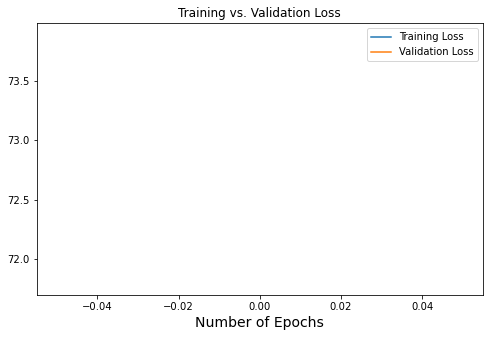

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

train_loss = model_history["loss"]
val_loss = model_history["val_loss"]
plt.figure(figsize=(8, 5))
plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Number of Epochs", size=14)
plt.legend()
plt.show()
plt.savefig(pwd+model_name+"_loss.png",transparent=True, format="png")

## Visually Inspect Prediction

In [24]:
slice_val = SliceGenerator(img_dir=train_file_path, slice_size=frames, vars_=vars_,
                     proc_type=proc_type, pixels_x=pixels_x, pixels_y=pixels_y, debug=False
                     )

In [30]:
in_, out_ = next(slice_val)
in_

array([[[[283.55396, 283.605  , 283.6125 , 282.72177, 283.09116,
          282.4309 , 278.5678 , 275.39362, 273.51315, 275.51074,
          279.59866, 279.74567, 277.39743, 275.67142, 272.14594,
          268.67715, 267.82132, 266.7593 , 266.14017, 266.12396,
          265.9639 ],
         [283.57574, 283.51096, 283.84296, 283.44058, 283.50537,
          284.45837, 282.4172 , 277.9057 , 273.10455, 275.79974,
          279.2393 , 281.2549 , 280.12253, 279.40558, 276.76273,
          272.84296, 269.2589 , 267.03836, 265.52103, 265.4874 ,
          267.33112],
         [283.6866 , 283.57574, 283.72772, 283.68848, 283.91895,
          284.5792 , 282.58725, 279.28662, 275.8527 , 275.41357,
          278.32364, 281.08298, 282.5424 , 282.16928, 280.60837,
          278.08694, 273.40353, 268.9076 , 265.2725 , 263.9819 ,
          263.212  ],
         [283.69846, 283.6947 , 283.51907, 283.5776 , 283.57138,
          282.5287 , 280.2689 , 278.11435, 277.23734, 276.47556,
          278.56158, 280

In [31]:
test_pred= model.predict(in_, verbose=1)
test_pred

1/1 [==============================] - 0s 15ms/step


array([[[[[286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886],
          [286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886],
          [286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886],
          [286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
           286.14886, 286.14886, 286.14886, 286.14886, 286.14886,
       